# Text classification on real data.

This notebook based on my laboratory work. Only minor adjustments have been made.

## Getting data

The reviews were taken from the marketplace https://www.wildberries.ru. A parser was developed that uses the `requests` and `pydantic` libraries. The data on the site page is loaded dynamically using requests to the API (for example, to server with reviews, to server with product catalogs, etc.). Using the `requests` library functions, requests are made to wildberries, then the response is parsed according to the specified data models and their attributes based on the `pydantic` class.

- `models.py ` stores data models;
- `parser.py ` implements the parser class;

The algorithm of the parser:

- Initializes the parser class with links to different product from the marketplace
- The product ID is parsed from the link using the `re` regular expression library
- A request is made to wildberries, with the parameter obtained in the previous step, and the ID of the seller is extracted from the request, whose goods will then be parsed in the cycle
- A csv file is created with the columns `name`, `brand`, `price`, `sale`, ` price_with_sale`, `number of photos in the card - pics`, `pros`, `cons`, `availability of photos in the review - hasPhoto`, `useful`, `useless`, `text`, `rating - target`
- As long as the server returns a non-empty json response, we make a request to it, receiving a list of the seller's products page by page, with the fields above
- Receiving a list of products, we make a request to the server with feedback - reviews for one product from the list, process the received data and put them in a csv file

As links to products, I randomly selected products from the site from different categories of different sellers to make the sample representative.

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from pymorphy3 import MorphAnalyzer

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score


%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ibasl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Cleaning data and descriptive statistics

Read data, rename columns from Russian to English

In [2]:
df = pd.read_csv("../../data/dataset.csv")
df.rename(columns={
    "название": "name",
    "бренд": "brand",
    "цена": "price",
    "скидка в %": "sale",
    "цена со скидкой": "price_with_sale",
    "кол-во фото в карточке": "pics",
    "плюсы": "pros",
    "минусы": "cons",
    "наличие фото в отзыве": "hasPhoto",
    "полезно": "useful",
    "неполезно": "useless",
    "текст отзыва": "text",
    'рейтинг': 'target',},
    inplace=True)
df.head()

C:\Users\ibasl\AppData\Local\Temp\ipykernel_17344\2546511965.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../data/dataset.csv")


,name,brand,price,sale,price_with_sale,pics,pros,cons,hasPhoto,useful,useless,text,target
0,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,204.0,5,NaN,NaN,False,0,1,отличные кусачки заточены хорошо со своей зада...,5
1,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,204.0,5,NaN,NaN,False,0,1,спасибо за качественный товар буду рекомендова...,5
2,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,204.0,5,NaN,NaN,False,0,0,щипчики хорошо стригут ногти все отлично,5
3,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,204.0,5,NaN,NaN,False,0,0,хороший набор пришло все целое,5
4,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,204.0,5,NaN,NaN,False,0,0,получили кусочки пришли быстро и хорошо упаков...,5


Drop duplicates and view shape

In [3]:
df.drop_duplicates(inplace=True)
df.shape

(381859, 13)

Main information about dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381859 entries, 0 to 461663
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   name             381859 non-null  object 
 1   brand            381857 non-null  object 
 2   price            381859 non-null  float64
 3   sale             381859 non-null  int64  
 4   price_with_sale  381859 non-null  float64
 5   pics             381859 non-null  int64  
 6   pros             0 non-null       float64
 7   cons             0 non-null       float64
 8   hasPhoto         381033 non-null  object 
 9   useful           381859 non-null  int64  
 10  useless          381859 non-null  int64  
 11  text             380199 non-null  object 
 12  target           381859 non-null  int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 40.8+ MB


Change type of `hasPhoto` column

In [5]:
df['hasPhoto'] = df['hasPhoto'].astype(bool)

Descriptive statistics

In [6]:
df.describe()

,price,sale,price_with_sale,pics,pros,cons,useful,useless,target
count,381859.000000,381859.000000,381859.000000,381859.000000,0.0,0.0,381859.000000,381859.000000,381859.000000
mean,8620.201093,58.793353,3335.807565,6.952530,NaN,NaN,1.337533,0.393635,4.517107
std,17832.819749,20.181132,6753.828420,4.154662,NaN,NaN,4.079684,1.848265,1.095853
min,99.000000,0.000000,85.000000,1.000000,NaN,NaN,0.000000,0.000000,1.000000
25%,1500.000000,59.000000,465.000000,4.000000,NaN,NaN,0.000000,0.000000,5.000000
50%,3200.000000,66.000000,1288.000000,6.000000,NaN,NaN,0.000000,0.000000,5.000000
75%,7030.000000,70.000000,3146.000000,9.000000,NaN,NaN,1.000000,0.000000,5.000000
max,629990.000000,93.000000,239396.000000,26.000000,NaN,NaN,332.000000,362.000000,5.000000


Descriptive statistics of object columns

In [7]:
df.describe(include=['O'])

,name,brand,text
count,381859,381857,380199
unique,2012,102,201389
top,Ювелирные серьги женские из серебра 925,SOKOLOV,все отлично
freq,9322,178255,716


Amount of missed values

In [8]:
df.isna().sum()

name                    0
brand                   2
price                   0
sale                    0
price_with_sale         0
pics                    0
pros               381859
cons               381859
hasPhoto                0
useful                  0
useless                 0
text                 1660
target                  0
dtype: int64

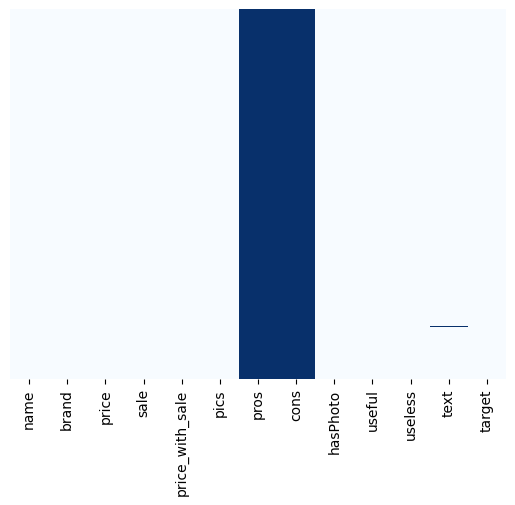

In [9]:
sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap='Blues');

`pros` and `cons` columns contain only empty values, remove them. Also we delete all the remaining  missed values because we have a lot of data 

In [10]:
df.drop(columns=['pros', 'cons'], inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(subset=['text'], inplace=True)
df.shape

(201388, 11)

Correlation matrix

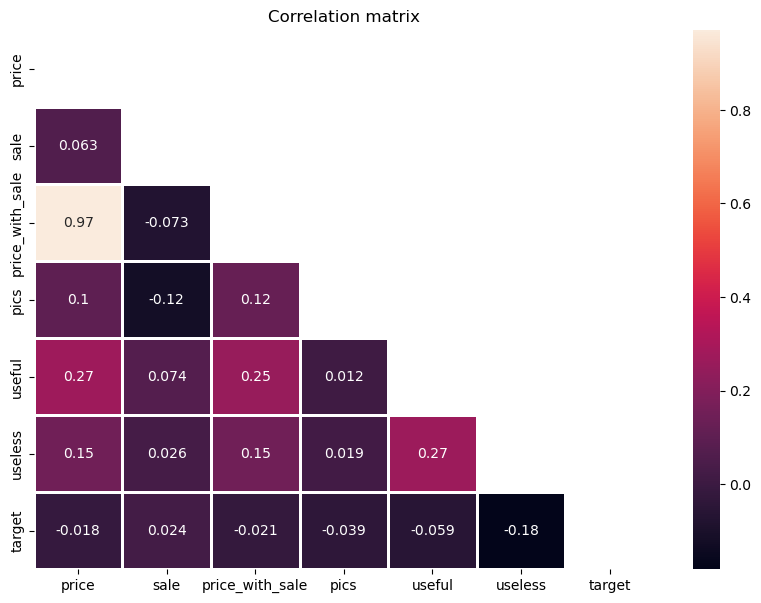

In [11]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_ = df[numeric_cols]
corr = df_.corr()
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (10,7))
plt.title('Correlation matrix')
sns.heatmap(corr,
            mask=mask,
            annot=True,
            fmt='.2g',
            linewidths=2);

`price_with_sale` and `price` correlate with the value 0.97. Delete `price_with_sale`

In [12]:
df.drop(columns=['price_with_sale'], inplace=True)

Look at the outliers in numerical data using the boxplot

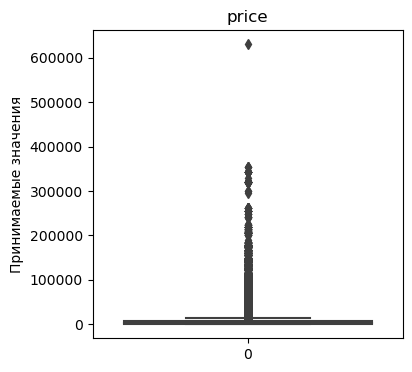

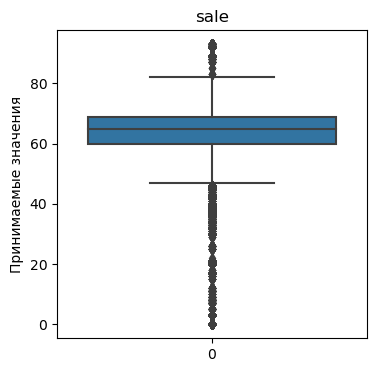

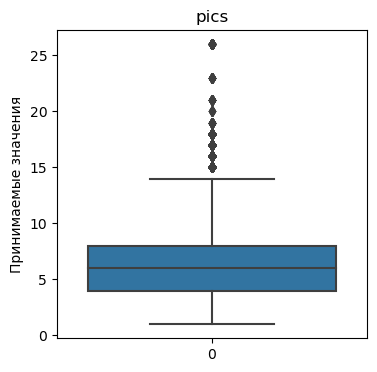

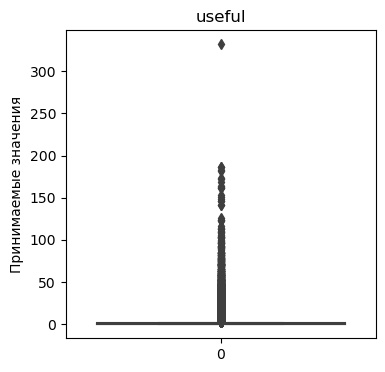

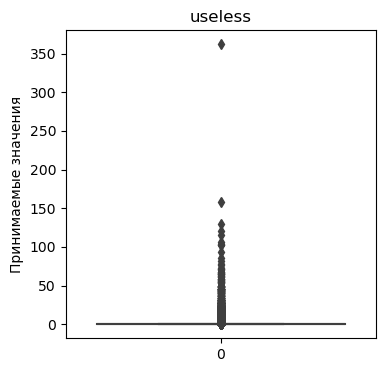

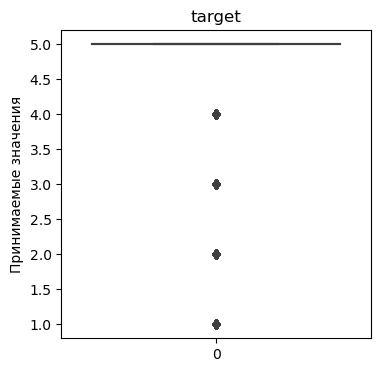

In [13]:
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_columns:
    plt.figure(figsize=(4,4))
    sns.boxplot(data=df[col])
    plt.title(f'{col}')
    plt.ylabel('Принимаемые значения');

In my opinion, we can remove a little bit of outliers in the `useful` and `useless` columns,

In [14]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)].shape

(174487, 10)

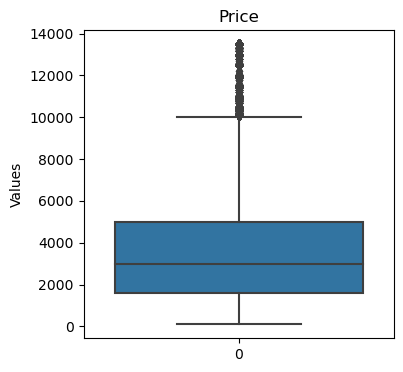

In [15]:
plt.figure(figsize=(4,4))
sns.boxplot(data=df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]['price'])
plt.title(f'Price')
plt.ylabel('Values');

We will remove ~15% of the emissions from the `price` column. There is a lot of data, it is not critical.

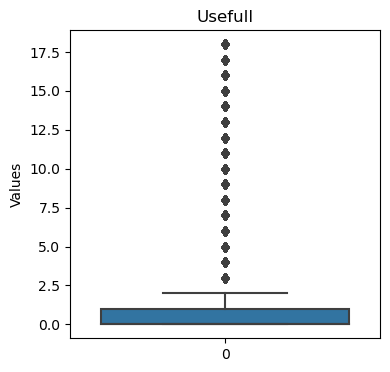

In [16]:
plt.figure(figsize=(4,4))
sns.boxplot(data=df['useful'][df['useful'] < df['useful'].quantile(0.99)])
plt.title(f'Usefull')
plt.ylabel('Values');

In [17]:
df['useful'].value_counts()

useful
0      112014
1       40038
2       17313
3        8874
4        5513
        ...  
65          1
108         1
110         1
114         1
90          1
Name: count, Length: 127, dtype: int64

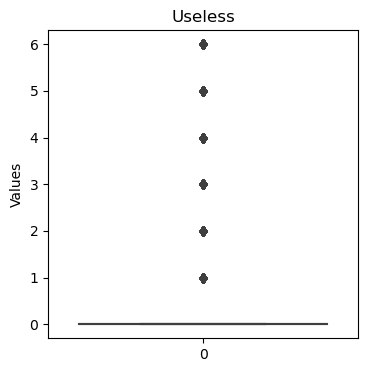

In [18]:
plt.figure(figsize=(4,4))
sns.boxplot(data=df['useless'][df['useless'] < df['useless'].quantile(0.99)])
plt.title(f'Useless')
plt.ylabel('Values');

In [19]:
df['useless'].value_counts()

useless
0      160961
1       24610
2        7409
3        3169
4        1610
        ...  
103         1
63          1
82          1
47          1
72          1
Name: count, Length: 82, dtype: int64

Delete 1% of `useless` and `useful`.

In [20]:
df = df[df['price'] < df['price'].quantile(0.85)]
df = df[df['useless'] < df['useless'].quantile(0.99)]
df = df[df['useful'] < df['useful'].quantile(0.99)]
df.shape

(166779, 10)

Look at the basic information of the cleaned dataset

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 166779 entries, 0 to 461608
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   name      166779 non-null  object 
 1   brand     166779 non-null  object 
 2   price     166779 non-null  float64
 3   sale      166779 non-null  int64  
 4   pics      166779 non-null  int64  
 5   hasPhoto  166779 non-null  bool   
 6   useful    166779 non-null  int64  
 7   useless   166779 non-null  int64  
 8   text      166779 non-null  object 
 9   target    166779 non-null  int64  
dtypes: bool(1), float64(1), int64(5), object(3)
memory usage: 12.9+ MB


## EDA

In [22]:
df.head()

,name,brand,price,sale,pics,hasPhoto,useful,useless,text,target
0,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,5,False,0,1,отличные кусачки заточены хорошо со своей зада...,5
1,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,5,False,0,1,спасибо за качественный товар буду рекомендова...,5
2,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,5,False,0,0,щипчики хорошо стригут ногти все отлично,5
3,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,5,False,0,0,хороший набор пришло все целое,5
4,"Клиппер маникюрный, кусачки для ногтей",Zebo Professional,499.0,59,5,False,0,0,получили кусочки пришли быстро и хорошо упаков...,5


### Target  `rating`

In [23]:
df['target'].value_counts()

target
5    134566
4     12441
1      8079
3      7812
2      3881
Name: count, dtype: int64

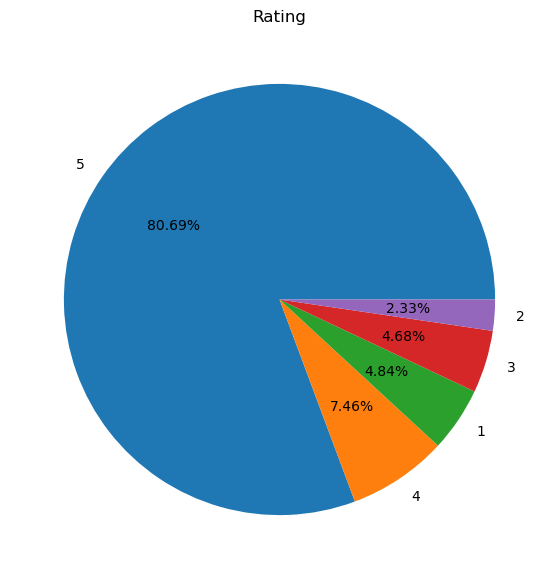

In [24]:
df["target"].value_counts().plot(
                                 kind='pie',
                                 title='Rating',
                                 figsize=(7, 7),
                                 autopct='%.2f%%')
plt.ylabel('');

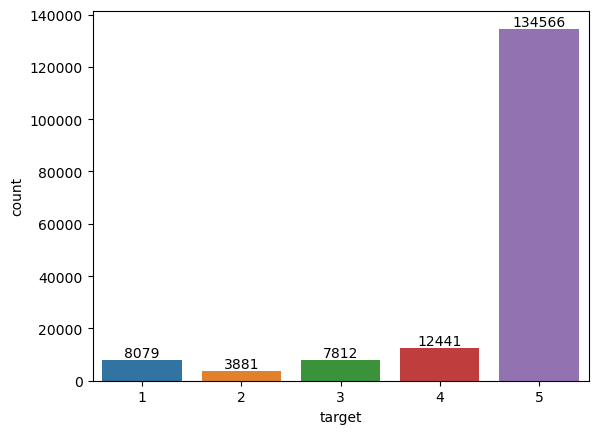

In [25]:
ax = sns.countplot(x='target', data=df)
ax.bar_label(ax.containers[0]);

Classes are not balanced - there are too many "5" and too few other grades, they are 4 times less. Since there is a lot of data, we will do undersampling. Each class will have 3800 - this is enough for our model to have good generalization capability.

In addition, it can be concluded that in 4 out of 5 cases, the buyer is satisfied with the purchased product, which is a good indicator.

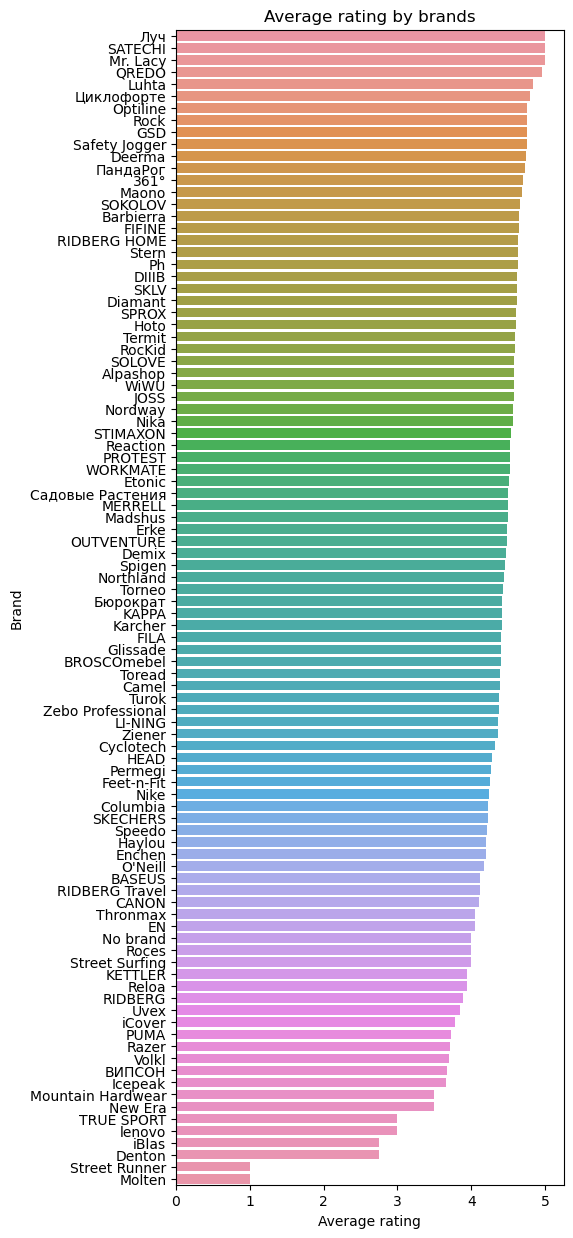

In [26]:
avg_rate_by_brand = pd.DataFrame(df.groupby('brand')['target'].mean())\
                                    .reset_index()\
                                    .sort_values(by='target', ascending=False)

plt.figure(figsize=(5, 15))
sns.barplot(x='target', y='brand', data=avg_rate_by_brand, orient='h')
plt.xlabel('Average rating')
plt.ylabel('Brand')
plt.title('Average rating by brands')
plt.show()

Most brands keep the quality - the average rating is 4 or higher, but there are also unscrupulous ones who sell goods of poor quality, which have a rating of 3 or lower, but there are only 6 such manufacturers.

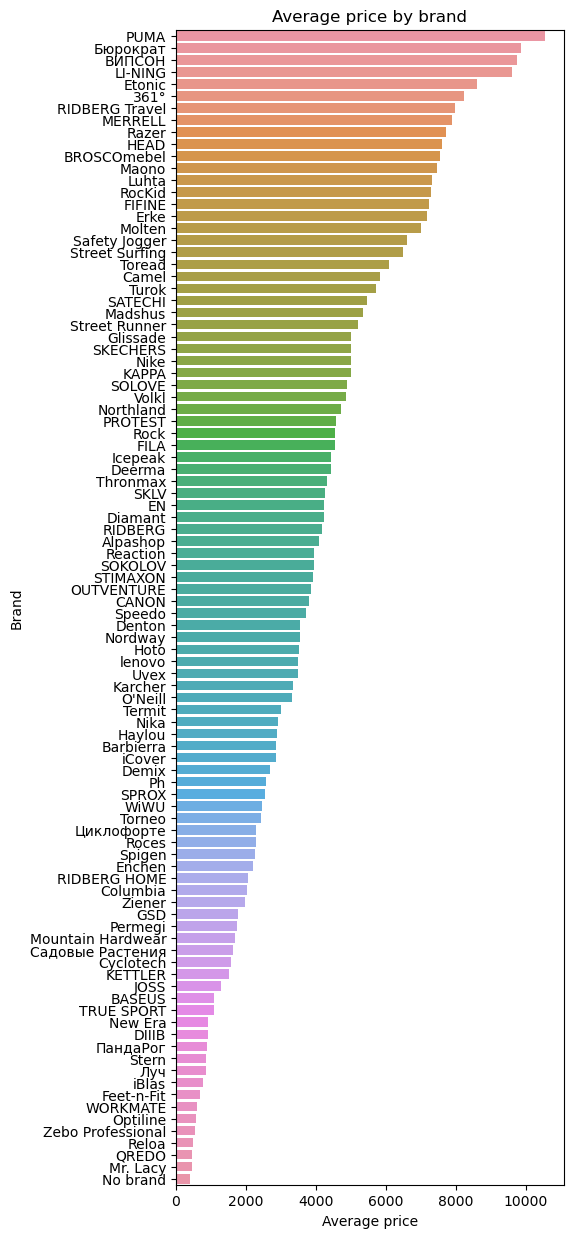

In [27]:
avg_price_by_brand = pd.DataFrame(df.groupby('brand')['price'].mean())\
                                    .reset_index()\
                                    .sort_values(by='price', ascending=False)

plt.figure(figsize=(5, 15))
sns.barplot(x='price', y='brand', data=avg_price_by_brand, orient='h')
plt.xlabel('Average price')
plt.ylabel('Brand')
plt.title('Average price by brand')
plt.show()

Most of the products of various brands are sold at an average price of up to ~5000 rubles.

It can also be noted that the closing three brands according to the average rating have a price for goods of 4-6 thousand rubles, i.e. for relatively big money, buyers receive a terrible product.

### Column `hasPhoto`

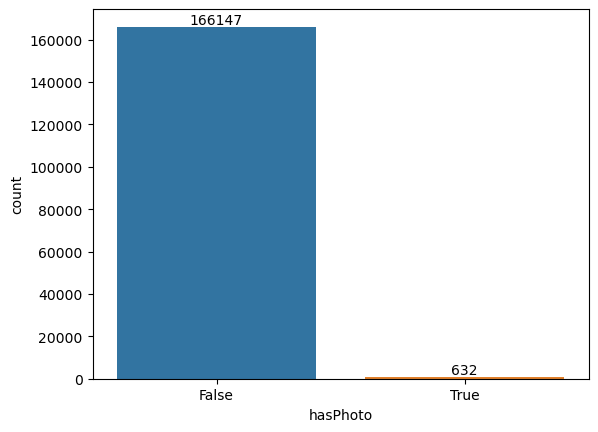

In [28]:
ax = sns.countplot(x='hasPhoto', data=df)
ax.bar_label(ax.containers[0]);

**Conclusion:** the vast majority of users prefer to leave reviews without photos.

### Column `sale`

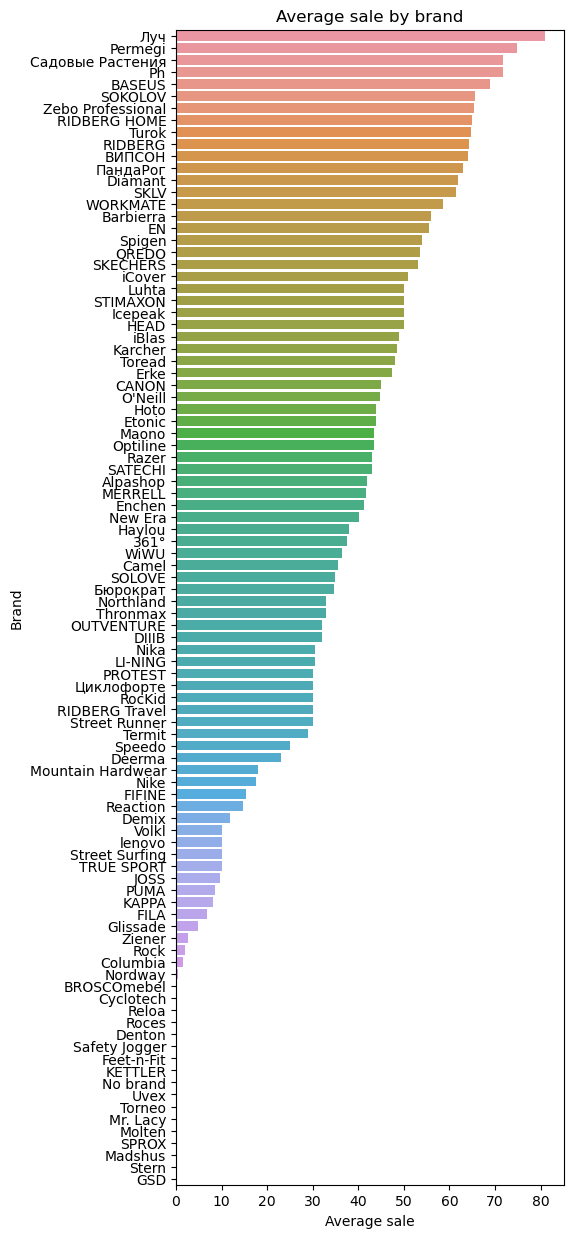

In [29]:
avg_sale_by_brand = pd.DataFrame(df.groupby('brand')['sale'].mean())\
                                    .reset_index()\
                                    .sort_values(by='sale', ascending=False)

plt.figure(figsize=(5, 15))
sns.barplot(x='sale', y='brand', data=avg_sale_by_brand, orient='h')
plt.xlabel('Average sale')
plt.ylabel('Brand')
plt.title('Average sale by brand')
plt.show()

About half of the brands have a discount of more than 40%, which is undoubtedly a cheat, since this is done to promote product cards to the top of the list and create the effect of acquiring benefits for the buyer. About 20% of brands do not have a discount.

### Column `pics` - number of images in product card

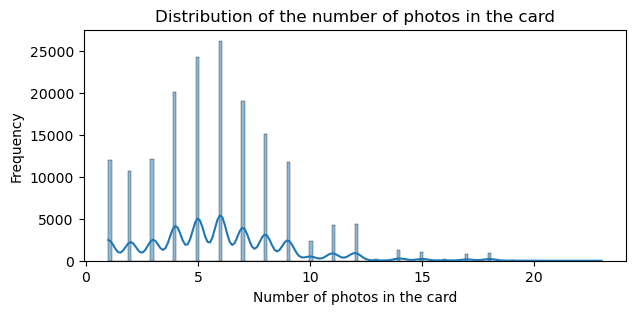

In [30]:
plt.figure(figsize=(7,3))
sns.histplot(x=df['pics'], kde=True)
plt.title('Distribution of the number of photos in the card')
plt.xlabel('Number of photos in the card')
plt.ylabel('Frequency');

Most often, sellers take from 1 to 9 photos in the card. Let's look at the product rating depending on the number of photos in the product card

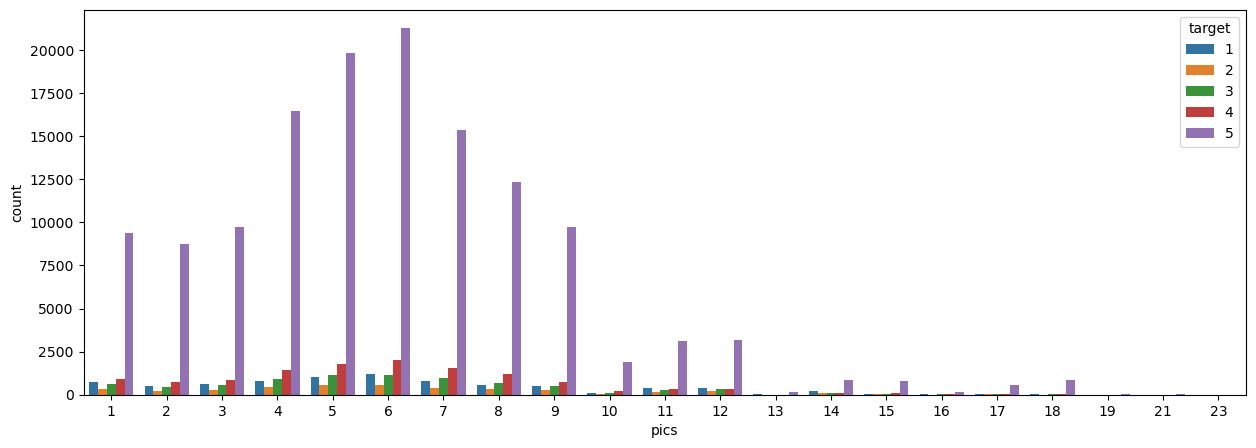

In [31]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x='pics', data=df, hue='target');

There is no special dependence 

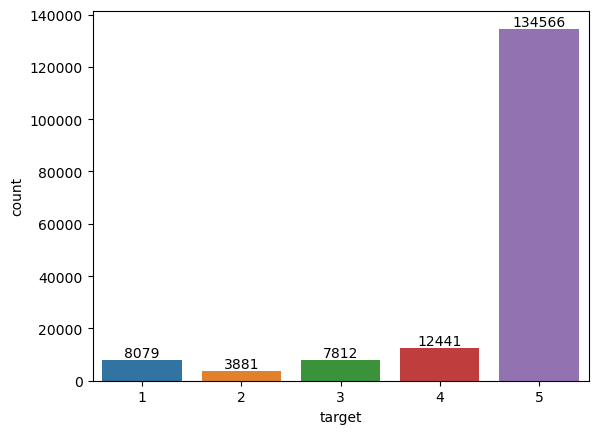

In [32]:
ax = sns.countplot(x='target', data=df)
ax.bar_label(ax.containers[0]);

As I said earlier, the classes are unbalanced, and due to the fact that there is a lot of data, we will do undersampling

## Text processing

### Word cloud

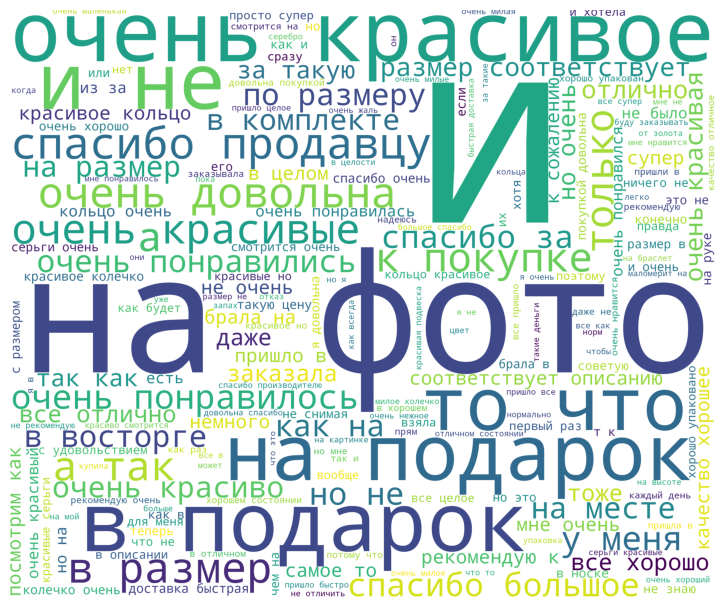

In [33]:
# get list of words from string
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus


# get all words in corpus
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus


# getting word clord
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                          stopwords=STOPWORDS,
                          width=3000,
                          height=2500,
                          max_words=200,
                          random_state=42
                          ).generate(str_corpus(corpus))
    return wordCloud


corpus = get_corpus(df['text'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1);

Drop stopwords and look again

In [34]:
russian_stopwords = stopwords.words("russian")

df['text'] = df['text'].map(lambda x: x.split(' '))
df['text'] = df['text'].map(lambda x: [token for token in x if token not in russian_stopwords\
                                                                  and token != " "])
df['text'] = df['text'].map(lambda x: ' '.join(x))

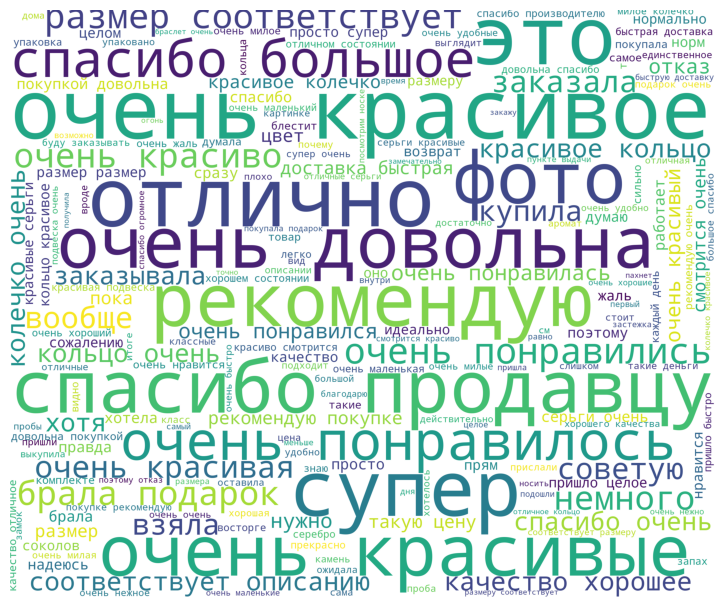

In [35]:
corpus = get_corpus(df['text'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1);

A lot of positive russian words because 80% of our dataset has an excellent rating. Let's rebalance and look at the word cloud again.

In [36]:
X = df.drop('target', axis=1)
y = df['target']

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_resampled, y_resampled = rus.fit_resample(X, y)

In [37]:
y_resampled.value_counts()

target
1    3881
2    3881
3    3881
4    3881
5    3881
Name: count, dtype: int64

In [38]:
X_resampled.reset_index(drop=True, inplace=True)
y_resampled.reset_index(drop=True, inplace=True)

df = pd.concat([X_resampled, y_resampled], axis=1)

Now we have 5 balanced classes. Look at word cloud

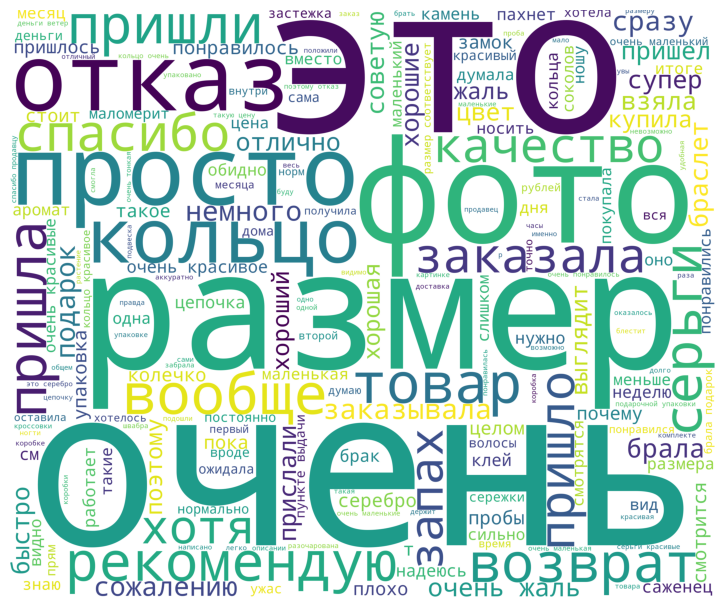

In [39]:
corpus = get_corpus(df['text'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1);

Due to the fact that more than half of the dataset consists of reviews of Sokolov(jewelery company) products, there are many words related to the subject of jewelry (for example, silver, earrings, ring, etc.)

### Processing of numerical and categorical features

Standardize numerical features, encode categorical features

In [40]:
numeric_columns

['price', 'sale', 'pics', 'useful', 'useless', 'target']

In [41]:
scaler = StandardScaler()
df[numeric_columns[:-1]] = scaler.fit_transform(df[numeric_columns[:-1]])

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [42]:
df

,name,brand,price,sale,pics,hasPhoto,useful,useless,text,target
0,Шлепанцы Mono,FILA,-0.144880,-2.472030,-0.618441,False,-0.030635,0.600217,пришли абсолютно схожи оригиналом фото китайск...,1
1,Кольцо из серебра,SOKOLOV,0.178815,0.401142,-0.925706,False,0.518779,-0.542338,кольцо пришло согнутое думаю продавцу нужно пе...,1
2,Ювелирный каучуковый шнурок с замком из серебр...,SOKOLOV,0.015126,0.575274,-0.925706,False,1.617607,0.600217,шнурок вместо сильно разочаровал ваш товар хот...,1
3,Ювелирные серьги кольца серебро 925,SOKOLOV,-0.230407,0.314076,-0.618441,False,-0.580049,-0.542338,серьги еле надела это кошмар,1
4,Женские серьги пусеты гвоздики из золота 585 п...,SOKOLOV,2.715995,0.357609,0.610619,False,-0.580049,1.742772,понравилась застежка,1
...,...,...,...,...,...,...,...,...,...,...
19400,Астильба Арендса Mix,Садовые Растения,-0.962916,0.749406,-1.540236,False,-0.030635,-0.542338,шикарный саженец огромное спасибо,5
19401,Кольцо из серебра с фианитом,SOKOLOV,-0.312252,0.314076,-0.311176,False,-0.580049,-0.542338,отлично рада,5
19402,Женское кольцо на помолвку из серебра 925,SOKOLOV,0.015126,0.314076,0.917884,False,-0.580049,-0.542338,маленькое аккуратное,5
19403,Ювелирная подвеска кулон на шею серебро 925,SOKOLOV,-0.475941,0.314076,0.610619,False,2.167021,0.600217,подвеска очень хорошая похожа золото переворач...,5


Encode categorical features

In [43]:
df['brand'].value_counts()

brand
SOKOLOV              9423
Zebo Professional    2060
Садовые Растения     1413
Demix                 911
Permegi               650
                     ... 
Mountain Hardwear       1
HEAD                    1
Denton                  1
Street Surfing          1
QREDO                   1
Name: count, Length: 86, dtype: int64

In [44]:
df['name'].value_counts()

name
Ювелирные серьги женские из серебра 925            711
Кольцо из серебра с фианитами                      667
Цепочка на шею из серебра 925                      423
Ювелирные серьги пусеты-гвоздики из серебра 925    394
Ювелирная цепочка на шею серебро 925               391
                                                  ... 
Куртка софтшелл женская                              1
Ролики JUNIOR GIRL                                   1
Перчатки сноубордические KAILA                       1
Виноград девичий Yellow Wall                         1
Куртка утепленная для девочек                        1
Name: count, Length: 988, dtype: int64

Encode `brand` by OneHotEncoder and remove its column

In [45]:
brand = pd.get_dummies(df["brand"], drop_first=True, dtype=int)
df.drop(columns=["name", "brand"], inplace=True)
df = pd.concat([df, brand], axis=1)
df.head()

,price,sale,pics,hasPhoto,useful,useless,text,target,Alpashop,BASEUS,...,WiWU,Zebo Professional,Ziener,iBlas,iCover,lenovo,Бюрократ,ПандаРог,Садовые Растения,Циклофорте
0,-0.144880,-2.472030,-0.618441,False,-0.030635,0.600217,пришли абсолютно схожи оригиналом фото китайск...,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.178815,0.401142,-0.925706,False,0.518779,-0.542338,кольцо пришло согнутое думаю продавцу нужно пе...,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.015126,0.575274,-0.925706,False,1.617607,0.600217,шнурок вместо сильно разочаровал ваш товар хот...,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.230407,0.314076,-0.618441,False,-0.580049,-0.542338,серьги еле надела это кошмар,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.715995,0.357609,0.610619,False,-0.580049,1.742772,понравилась застежка,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Encode `hasPhoto` by OneHotEncoder

In [46]:
has_photo = pd.get_dummies(df["hasPhoto"], drop_first=True, dtype=int)
df.drop(columns=["hasPhoto"], inplace=True)
df = pd.concat([df, has_photo], axis=1)
df.head()

,price,sale,pics,useful,useless,text,target,Alpashop,BASEUS,Barbierra,...,Zebo Professional,Ziener,iBlas,iCover,lenovo,Бюрократ,ПандаРог,Садовые Растения,Циклофорте,True
0,-0.144880,-2.472030,-0.618441,-0.030635,0.600217,пришли абсолютно схожи оригиналом фото китайск...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.178815,0.401142,-0.925706,0.518779,-0.542338,кольцо пришло согнутое думаю продавцу нужно пе...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.015126,0.575274,-0.925706,1.617607,0.600217,шнурок вместо сильно разочаровал ваш товар хот...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.230407,0.314076,-0.618441,-0.580049,-0.542338,серьги еле надела это кошмар,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.715995,0.357609,0.610619,-0.580049,1.742772,понравилась застежка,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Text processing

In [47]:
morph = MorphAnalyzer()
def lemmatize(doc):
    tokens = []
    for token in doc.split():
        if token:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 0:
        return " ".join(tokens)
    return None

df["text"] = df["text"].apply(lemmatize)
df.head()

,price,sale,pics,useful,useless,text,target,Alpashop,BASEUS,Barbierra,...,Zebo Professional,Ziener,iBlas,iCover,lenovo,Бюрократ,ПандаРог,Садовые Растения,Циклофорте,True
0,-0.144880,-2.472030,-0.618441,-0.030635,0.600217,прислать абсолютно схожий оригинал фото китайс...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.178815,0.401142,-0.925706,0.518779,-0.542338,кольцо прийти согнутый думать продавец нужно п...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.015126,0.575274,-0.925706,1.617607,0.600217,шнурок вместо сильно разочаровать ваш товар хо...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.230407,0.314076,-0.618441,-0.580049,-0.542338,серьга еле надеть это кошмар,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.715995,0.357609,0.610619,-0.580049,1.742772,понравиться застёжка,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df["text"].isna().sum()

6

In [49]:
df.dropna(inplace=True)

In [50]:
df.head()

,price,sale,pics,useful,useless,text,target,Alpashop,BASEUS,Barbierra,...,Zebo Professional,Ziener,iBlas,iCover,lenovo,Бюрократ,ПандаРог,Садовые Растения,Циклофорте,True
0,-0.144880,-2.472030,-0.618441,-0.030635,0.600217,прислать абсолютно схожий оригинал фото китайс...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.178815,0.401142,-0.925706,0.518779,-0.542338,кольцо прийти согнутый думать продавец нужно п...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.015126,0.575274,-0.925706,1.617607,0.600217,шнурок вместо сильно разочаровать ваш товар хо...,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.230407,0.314076,-0.618441,-0.580049,-0.542338,серьга еле надеть это кошмар,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.715995,0.357609,0.610619,-0.580049,1.742772,понравиться застёжка,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
corpus = df["text"].to_list()

vectorizer = TfidfVectorizer()

X_tf_idf = vectorizer.fit_transform(corpus)

X_tf_idf

<19399x12312 sparse matrix of type '<class 'numpy.float64'>'
	with 189726 stored elements in Compressed Sparse Row format>

In [52]:
tfidf_df = pd.DataFrame(X_tf_idf.toarray(), columns=vectorizer.get_feature_names_out())

In [53]:
df.reset_index(drop=True, inplace=True)
tfidf_df.reset_index(drop=True, inplace=True)

df = pd.concat([df, tfidf_df], axis=1)

In [54]:
df.drop(columns=["text"], inplace=True)

In [55]:
df.columns = df.columns.astype(str)

In [56]:
X = df.drop(columns=["target"])
y = df["target"]

In [57]:
y.shape, X.shape, df.shape

((19399,), (19399, 12403), (19399, 12404))

## Trainig model

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

### KNN

In [59]:
knnclf = KNeighborsClassifier()

#### Train

In [60]:
%%time
knnclf.fit(X_train, y_train)

CPU times: total: 2.02 s
Wall time: 7.08 s


KNeighborsClassifier()

#### Test

In [61]:
%%time
y_pred = knnclf.predict(X_test)
print(f'accuracy {accuracy_score(y_pred, y_test):.2}')
print(classification_report(y_test, y_pred))

accuracy 0.33
              precision    recall  f1-score   support

           1       0.34      0.46      0.39       767
           2       0.26      0.27      0.26       773
           3       0.24      0.19      0.21       792
           4       0.30      0.25      0.27       785
           5       0.48      0.47      0.47       763

    accuracy                           0.33      3880
   macro avg       0.32      0.33      0.32      3880
weighted avg       0.32      0.33      0.32      3880

CPU times: total: 1min 46s
Wall time: 11.7 s


### Random Forest

In [62]:
rfc = RandomForestClassifier()

#### Train

In [63]:
%%time
rfc.fit(X_train, y_train)

CPU times: total: 1min 11s
Wall time: 1min 31s


RandomForestClassifier()

#### Test

In [64]:
%%time
y_pred = rfc.predict(X_test)
print(f'accuracy {accuracy_score(y_pred, y_test):.2}')
print(classification_report(y_test, y_pred))

accuracy 0.45
              precision    recall  f1-score   support

           1       0.44      0.63      0.52       767
           2       0.32      0.26      0.29       773
           3       0.31      0.21      0.25       792
           4       0.42      0.36      0.39       785
           5       0.65      0.79      0.71       763

    accuracy                           0.45      3880
   macro avg       0.43      0.45      0.43      3880
weighted avg       0.43      0.45      0.43      3880

CPU times: total: 422 ms
Wall time: 640 ms


### AdaBoost

In [65]:
abc = AdaBoostClassifier()

#### Train

In [66]:
%%time
abc.fit(X_train, y_train)

CPU times: total: 56 s
Wall time: 1min 15s


AdaBoostClassifier()

#### Test

In [67]:
%%time
y_pred = abc.predict(X_test)
print(f'accuracy {accuracy_score(y_pred, y_test):.2}')
print(classification_report(y_test, y_pred))

accuracy 0.4
              precision    recall  f1-score   support

           1       0.43      0.55      0.49       767
           2       0.28      0.15      0.19       773
           3       0.28      0.30      0.29       792
           4       0.35      0.38      0.36       785
           5       0.62      0.64      0.63       763

    accuracy                           0.40      3880
   macro avg       0.39      0.40      0.39      3880
weighted avg       0.39      0.40      0.39      3880

CPU times: total: 4.5 s
Wall time: 6.32 s


### MLP

In [68]:
mlpc = MLPClassifier()

#### Train

In [69]:
%%time
mlpc.fit(X_train, y_train)

CPU times: total: 3h 57min 30s
Wall time: 49min 5s


C:\Users\ibasl\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

#### Test

In [70]:
%%time
y_pred = mlpc.predict(X_test)
print(f'accuracy {accuracy_score(y_pred, y_test):.2}')
print(classification_report(y_test, y_pred))

accuracy 0.41
              precision    recall  f1-score   support

           1       0.45      0.47      0.46       767
           2       0.32      0.32      0.32       773
           3       0.26      0.26      0.26       792
           4       0.38      0.35      0.36       785
           5       0.66      0.69      0.68       763

    accuracy                           0.41      3880
   macro avg       0.41      0.42      0.41      3880
weighted avg       0.41      0.41      0.41      3880

CPU times: total: 1.44 s
Wall time: 570 ms


In [71]:
column0 = ['KNN', 'Random Forest','AdaBoost','MLP']
column1 = ["8.49 s", '1min 23s', '1 min 10s', '36 min 18s']
column2 = ["658 ms", '1min 22s', '1min 5s', '36min 17s']
column3 = ['7.82 s', '605 ms', '5.12 s', '406 ms']
column4 = [0.33, 0.45, 0.4, 0.42]


data = {'Model': column0,
        'Run time': column1,
        'Traing time': column2,
        'Test time': column3,
        'Accuracy': column4}
table = pd.DataFrame(data)
table.set_index('Model', inplace=True)
table

,Run time,Traing time,Test time,Accuracy
Model,,,,
KNN,8.49 s,658 ms,7.82 s,0.33
Random Forest,1min 23s,1min 22s,605 ms,0.45
AdaBoost,1 min 10s,1min 5s,5.12 s,0.40
MLP,36 min 18s,36min 17s,406 ms,0.42


## Conclusion

The overall quality of the models is average - each of them is very close to random guessing the rating, with the exception of reviews with a rating of "5". The random forest and multilayer perceptron models distinguish five stars texts much better than the other - with 0.63 and 0.7 f1-score. In my opinion, this is due to four factors - the comments are not long enough for the model to extract the desired message; you need to use word embeddings instead of tf-idf vectorization; you need to use more complex algorithms, for example, deep learning with rnn or with attention layers; the authors' comments are biased and vary;

I said average quality because even modern BERT models do not give an accuracy of more than 0.6 due to the [article](https://arxiv.org/pdf/2005.13619.pdf)
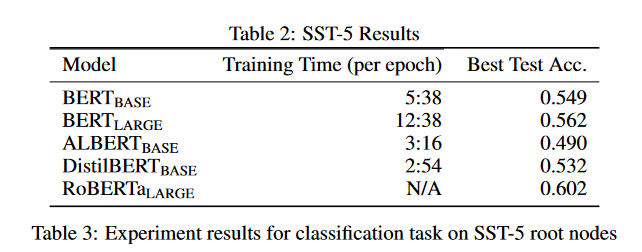